In [ ]:
!pip install spektral
!pip install tensorflow_privacy

     |████████████████████████████████| 123 kB 5.1 MB/s 
     |████████████████████████████████| 14.8 MB 41.9 MB/s 
     |████████████████████████████████| 495.0 MB 35 kB/s 
     |████████████████████████████████| 1.3 MB 35.8 MB/s 
     |████████████████████████████████| 463 kB 44.7 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling numpy-1.21.5:
      Successfully uninstalled numpy-1.21.5
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.5.3
  Attempting uninstall: tensorflow
    Found existing insta

     |████████████████████████████████| 287 kB 5.4 MB/s 
     |████████████████████████████████| 25.9 MB 1.6 MB/s 
     |████████████████████████████████| 9.5 MB 15.1 MB/s 
     |████████████████████████████████| 5.7 MB 19.4 MB/s 
     |████████████████████████████████| 11.5 MB 18.7 MB/s 
     |████████████████████████████████| 4.2 MB 19.7 MB/s 
     |████████████████████████████████| 53 kB 2.0 MB/s 
     |████████████████████████████████| 15.7 MB 39.7 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
  Attempting uninstall: tensorflow-probability
    Found existing installation: tensorflow-probability 0.16.0
    Uninstalling tensorflow-probability-0.16.0:


In [ ]:
import tensorflow as tf
from tensorflow.python.keras.utils.vis_utils import plot_model

# from spektral.data.loaders import SingleLoader
# from spektral.datasets.citation import Citation
# from spektral.layers import GCNConv
# from spektral.models.gcn import GCN
# from spektral.transforms import AdjToSpTensor, LayerPreprocess
from tqdm import tqdm
from sklearn.decomposition import TruncatedSVD
import scipy
import random
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
from sklearn import preprocessing
import networkx as nx

In [ ]:
hidden_neu = 128
inpdim = 6
outdim_1 = 4
outdim_2 = 2
def create_model_G(in_dim, outdim_1, outdim_2, hidden_neuron):
    inputs = tf.keras.Input(shape=(in_dim,))
    x = tf.keras.layers.Dense(hidden_neuron, activation='relu')(inputs)
    # x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(int(hidden_neuron/4), activation='relu')(x)
    op1 = tf.keras.layers.Dense(outdim_1, activation='relu')(x)
    op2 = tf.keras.layers.Dense(outdim_2, activation='sigmoid')(x)
    model = tf.keras.Model(inputs=inputs, outputs=[op1, op2])
    return model

model_g = create_model_G(inpdim, outdim_1, outdim_2, hidden_neu)   

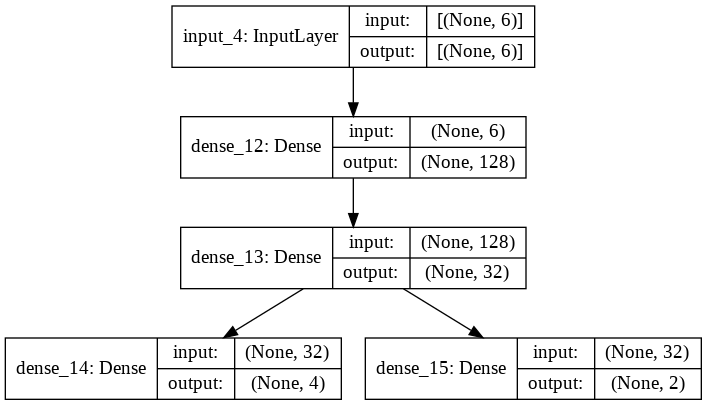

In [ ]:
plot_model(model_g, show_shapes=True, show_layer_names=True, to_file='base-model.png')

In [ ]:
def custom_loss(y_true, y_pred):
    loss_object1 = tf.keras.losses.MSE()
    loss_object2 = tf.keras.losses.BinaryCrossentropy()
    output_1, output_2 = y_pred
    true_1, true_2 = y_true
    loss1 = loss_object1(true_1, output_1)
    loss2 = loss_object2(true_2, output_2)
    return loss1 + loss2

In [ ]:
y1 = [e2, e3 ,dx2, dx3]
y2 = [s2, s3]
model.fit(X, y = [y1, y2])

In [ ]:
model.compile(optimizer='adam',
              loss=custom_loss,
              metrics=['mse'])

In [ ]:
def create_model_F(in_dim, out_dim, outdim_1, outdim_2, hidden_neuron):
    # old version of F
    inputs = tf.keras.Input(shape=(in_dim,))
    x = tf.keras.layers.Dense(512, activation='relu')(inputs)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    op1 = tf.keras.layers.Dense(out_dim, activation='relu')(x) # dau ra cua bai toan nguoc

    # structure of G
    y = tf.keras.layers.Dense(hidden_neuron, activation='relu')(op1)
    y = tf.keras.layers.Dense(int(hidden_neuron/4), activation='relu')(y)
    op2 = tf.keras.layers.Dense(outdim_1, activation='relu')(y)
    op3 = tf.keras.layers.Dense(outdim_2, activation='sigmoid')(y)
    model = tf.keras.Model(inputs=inputs, outputs=[op1, op2, op3])
    return model

In [ ]:
model_f = create_model_F(in_dim = 10, out_dim = 6, outdim_1 = 4, outdim_2 =2, hidden_neuron = hidden_neu)   

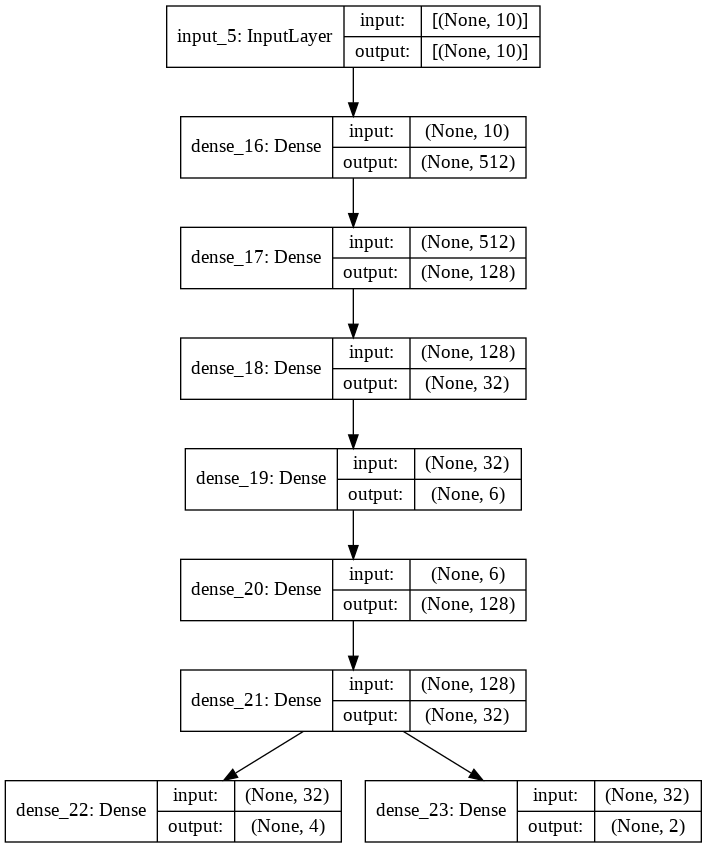

In [ ]:
plot_model(model_f, show_shapes=True, show_layer_names=True, to_file='base-model.png')

In [ ]:
model_f.outputs

[<KerasTensor: shape=(None, 6) dtype=float32 (created by layer 'dense_19')>,
 <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'dense_22')>,
 <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_23')>]

In [ ]:
# Parameters
result = []
channel_in = 512  
channel_mid = 128
channel_out = 32
dropout = 0.2          # Dropout rate for the features
l2_reg = 5e-4 / 2      # L2 regularization rate
learning_rate_user = 1e-3   # Learning rate
learning_rate_server = 1e-2
epoch_user = 5 
epoch_server = 70          
patience = 2
seed = 23
num_user = 3
# data = 'cora'
# alpha = 1
# sigma = 1
# q_u = 0.6

In [ ]:
tf.random.set_seed(seed=seed) 
def mask_to_weights(mask):
    return mask.astype(np.float32) / np.count_nonzero(mask)

# cora
dataset_cora = Citation('cora', normalize_x=True, transforms=[LayerPreprocess(GCNConv), AdjToSpTensor()])
weights_tr_cora, weights_va_cora, weights_te_cora = (mask_to_weights(mask) for mask in (dataset_cora.mask_tr, dataset_cora.mask_va, dataset_cora.mask_te))

# citeseer
dataset_citeseer = Citation('citeseer', normalize_x=True, transforms=[LayerPreprocess(GCNConv), AdjToSpTensor()])
weights_tr_citeseer, weights_va_citeseer, weights_te_citeseer = (mask_to_weights(mask) for mask in (dataset_citeseer.mask_tr, dataset_citeseer.mask_va, dataset_citeseer.mask_te))

# pubmed
dataset_pubmed = Citation('pubmed', normalize_x=True, transforms=[LayerPreprocess(GCNConv), AdjToSpTensor()])
weights_tr_pubmed, weights_va_pubmed, weights_te_pubmed = (mask_to_weights(mask) for mask in (dataset_pubmed.mask_tr, dataset_pubmed.mask_va, dataset_pubmed.mask_te))

Pre-processing node features


/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Pre-processing node features


/usr/local/lib/python3.7/dist-packages/spektral/datasets/citation.py:194: RuntimeWarning: divide by zero encountered in power
  r_inv = np.power(rowsum, -1).flatten()
/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Pre-processing node features


/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [ ]:
# cora
N_cora = dataset_cora.n_nodes
F_cora = dataset_cora.n_node_features
n_out_cora = dataset_cora.n_labels

# citeseer
N_citeseer = dataset_citeseer.n_nodes
F_citeseer = dataset_citeseer.n_node_features
n_out_citeseer = dataset_citeseer.n_labels

# pubmed
N_pubmed = dataset_pubmed.n_nodes
F_pubmed = dataset_pubmed.n_node_features
n_out_pubmed = dataset_pubmed.n_labels

In [ ]:
def create_model(num_node, num_feat, n_out, num_in, num_out, num_mid):
  x_in = tf.keras.Input(shape=(num_feat,))
  a_in = tf.keras.Input((num_node,), sparse=True, dtype=tf.float32)
  if (num_feat != num_in):
    x = tf.keras.layers.Dense(num_in, activation='relu')(x_in)
    gc_1 = GCNConv(num_mid, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg), use_bias=False)([x, a_in])
  else:
    gc_1 = GCNConv(num_mid, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg), use_bias=False)([x_in, a_in])
  do_1 = tf.keras.layers.Dropout(dropout)(gc_1)
  gc_2 = GCNConv(num_out, activation='relu', use_bias=False)([do_1, a_in])
  do_2 = tf.keras.layers.Dropout(dropout)(gc_2)
  out = tf.keras.layers.Dense(n_out, activation='softmax')(do_2)
  model = tf.keras.Model(inputs=[x_in, a_in], outputs=out)
  return model

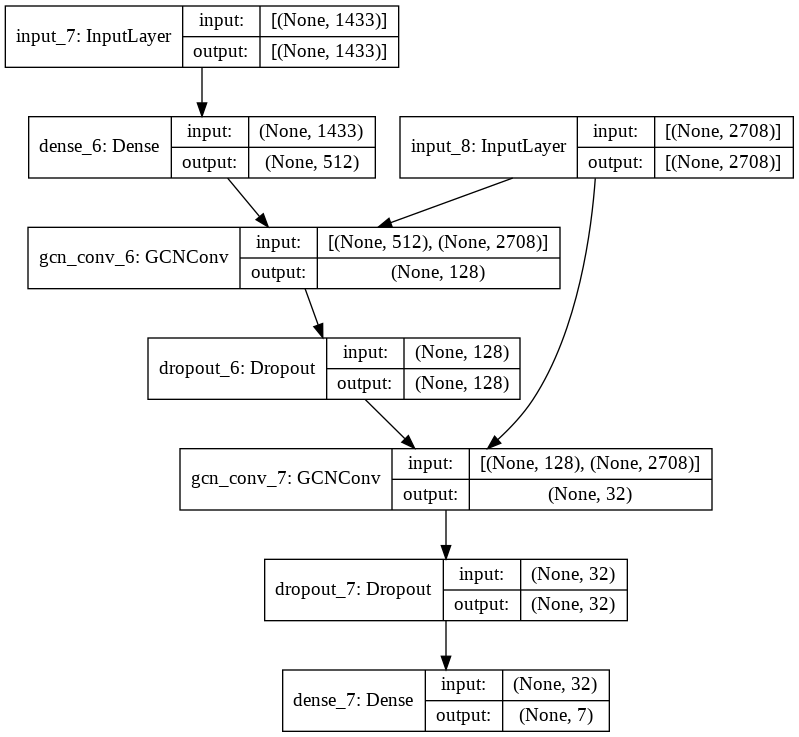

In [ ]:
model_cora = create_model(N_cora, F_cora, n_out_cora, channel_in, channel_out, channel_mid)
plot_model(model_cora, show_shapes=True, show_layer_names=True, to_file='base-model.png')

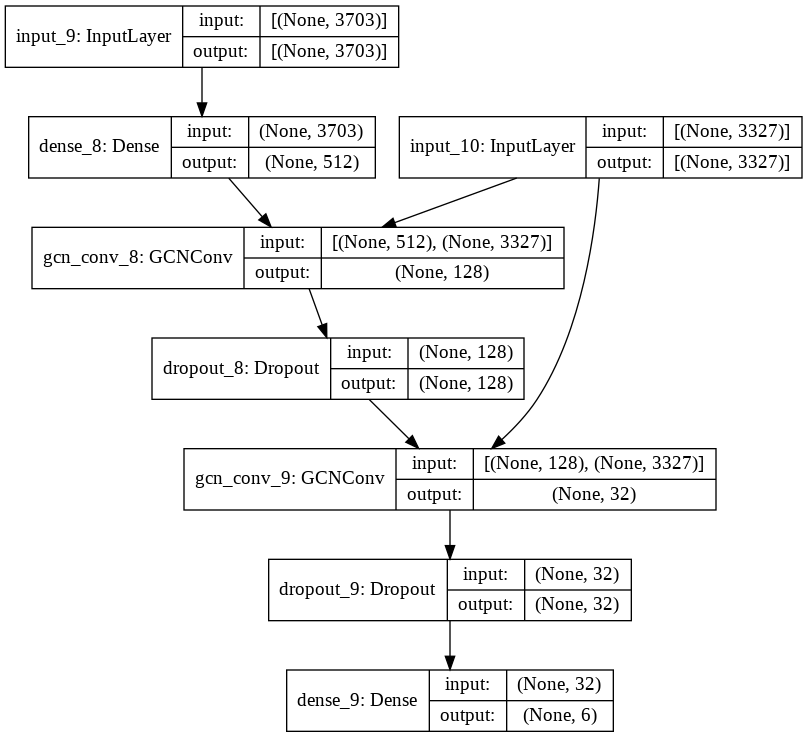

In [ ]:
model_citeseer = create_model(N_citeseer, F_citeseer, n_out_citeseer, channel_in, channel_out, channel_mid)
plot_model(model_citeseer, show_shapes=True, show_layer_names=True, to_file='base-model.png')

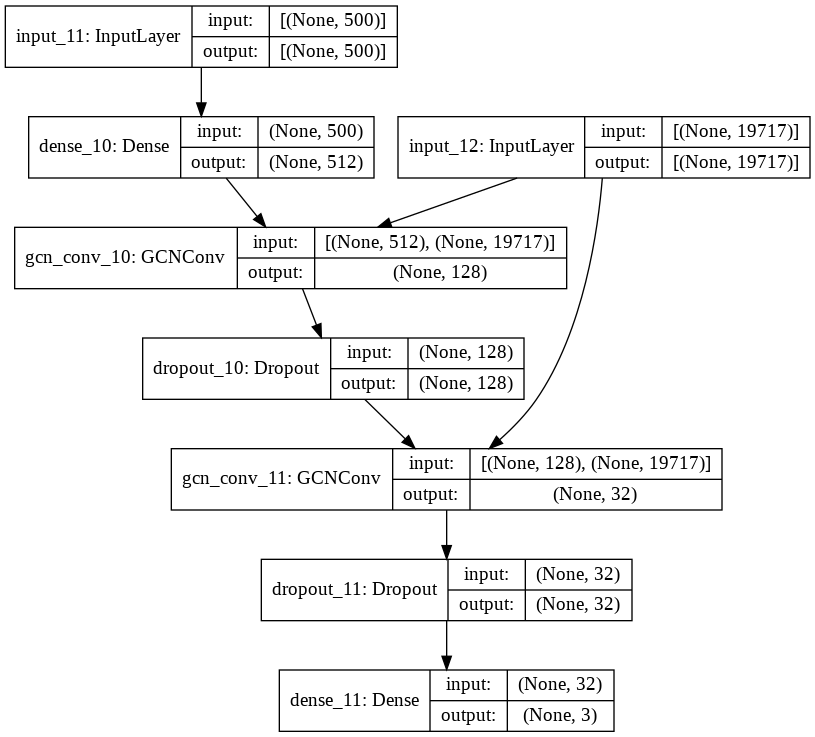

In [ ]:
model_pubmed = create_model(N_pubmed, F_pubmed, n_out_pubmed, channel_in, channel_out, channel_mid)
plot_model(model_pubmed, show_shapes=True, show_layer_names=True, to_file='base-model.png')

In [ ]:
print(model_cora.trainable_weights[2:-2][0].shape, model_cora.trainable_weights[2:-2][1].shape)
print(model_citeseer.trainable_weights[2:-2][0].shape, model_citeseer.trainable_weights[2:-2][1].shape)
print(model_pubmed.trainable_weights[2:-2][0].shape, model_pubmed.trainable_weights[2:-2][1].shape)

(512, 128) (128, 32)
(512, 128) (128, 32)
(512, 128) (128, 32)


In [ ]:
global_model = []
global_model.append((model_cora.trainable_weights[2:-2][0] + model_citeseer.trainable_weights[2:-2][0] + model_pubmed.trainable_weights[2:-2][0])/3)
global_model.append((model_cora.trainable_weights[2:-2][1] + model_citeseer.trainable_weights[2:-2][1] + model_pubmed.trainable_weights[2:-2][1])/3)

In [ ]:
user_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_user)
server_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_server)
loss_object = tf.keras.losses.CategoricalCrossentropy()
train_acc_metric = tf.keras.metrics.CategoricalAccuracy()
val_acc_metric = tf.keras.metrics.CategoricalAccuracy()

In [ ]:
def apply_gradient(optimizer, loss_object, model, x, y, mask):
  with tf.GradientTape() as tape:
    logits = model(x, training=True)
    loss_value = loss_object(y_true=y, y_pred=logits, sample_weight=mask)
  gradients = tape.gradient(loss_value, model.trainable_weights)
  optimizer.apply_gradients(zip(gradients, model.trainable_weights))
  return loss_value, logits

In [ ]:
# # cora
# loader_tr_cora = SingleLoader(dataset_cora, sample_weights=weights_tr_cora)
# loader_va_cora = SingleLoader(dataset_cora, sample_weights=weights_va_cora)
# loader_te_cora = SingleLoader(dataset_cora, sample_weights=weights_te_cora)

# # citeseer
# loader_tr_citeseer = SingleLoader(dataset_citeseer, sample_weights=weights_tr_citeseer)
# loader_va_citeseer = SingleLoader(dataset_citeseer, sample_weights=weights_va_citeseer)
# loader_te_citeseer = SingleLoader(dataset_citeseer, sample_weights=weights_te_citeseer)

# # pubmed
# loader_tr_pubmed = SingleLoader(dataset_pubmed, sample_weights=weights_tr_pubmed)
# loader_va_pubmed = SingleLoader(dataset_pubmed, sample_weights=weights_va_pubmed)
# loader_te_pubmed = SingleLoader(dataset_pubmed, sample_weights=weights_te_pubmed)

In [ ]:
loss_cora_train = []
loss_citeseer_train = []
loss_pubmed_train = []
loss_cora_valid = []
loss_citeseer_valid = []
loss_pubmed_valid = []

acc_cora_train = []
acc_citeseer_train = []
acc_pubmed_train = []
acc_cora_valid = []
acc_citeseer_valid = []
acc_pubmed_valid = []

In [ ]:
for server_epoch in range(epoch_server):
  model_cora.trainable_weights[2:-2] = global_model
  model_citeseer.trainable_weights[2:-2] = global_model
  model_pubmed.trainable_weights[2:-2] = global_model
  loss_train_cora = 0
  loss_valid_cora = 0
  loss_train_citeseer = 0
  loss_valid_citeseer = 0
  loss_train_pubmed = 0
  loss_valid_pubmed = 0
  acc_train_cora = 0
  acc_valid_cora = 0
  acc_train_citeseer = 0
  acc_valid_citeseer = 0
  acc_train_pubmed = 0
  acc_valid_pubmed = 0

  # cora
  for user_epoch in range(epoch_user):
    # train
    x = (dataset_cora[0].x, dataset_cora[0].a)
    y = dataset_cora[0].y
    mask = weights_tr_cora
    loss_value, logits = apply_gradient(optimizer=user_optimizer, loss_object=loss_object, model=model_cora, x=x, y=y, mask=mask)
    train_acc_metric.update_state(y, tf.cast(tf.round(logits), tf.int64), sample_weight=mask)
    loss_train_cora += loss_value
    acc_train_cora += train_acc_metric.result()
    # valid
    x = (dataset_cora[0].x, dataset_cora[0].a)
    y = dataset_cora[0].y
    mask = weights_va_cora
    val_logits = model_cora(x, training=False)
    val_acc_metric.update_state(y, tf.cast(tf.round(val_logits), tf.int64), sample_weight=mask)
    loss_valid_cora += loss_object(y_true=y, y_pred=val_logits, sample_weight=mask)
    acc_valid_cora += val_acc_metric.result()
  train_acc_metric.reset_states()
  val_acc_metric.reset_states()

  # citeseer
  for user_epoch in range(epoch_user):
    # train
    x = (dataset_citeseer[0].x, dataset_citeseer[0].a)
    y = dataset_citeseer[0].y
    mask = weights_tr_citeseer
    loss_value, logits = apply_gradient(optimizer=user_optimizer, loss_object=loss_object, model=model_citeseer, x=x, y=y, mask=mask)
    train_acc_metric.update_state(y, tf.cast(tf.round(logits), tf.int64), sample_weight=mask)
    loss_train_citeseer += loss_value
    acc_train_citeseer += train_acc_metric.result()
    # valid
    x = (dataset_citeseer[0].x, dataset_citeseer[0].a)
    y = dataset_citeseer[0].y
    mask = weights_va_citeseer
    val_logits = model_citeseer(x, training=False)
    val_acc_metric.update_state(y, tf.cast(tf.round(val_logits), tf.int64), sample_weight=mask)
    loss_valid_citeseer += loss_object(y_true=y, y_pred=val_logits, sample_weight=mask)
    acc_valid_citeseer += val_acc_metric.result()
  train_acc_metric.reset_states()
  val_acc_metric.reset_states()

  # pubmed
  for user_epoch in range(epoch_user):
    # train
    x = (dataset_pubmed[0].x, dataset_pubmed[0].a)
    y = dataset_pubmed[0].y
    mask = weights_tr_pubmed
    loss_value, logits = apply_gradient(optimizer=user_optimizer, loss_object=loss_object, model=model_pubmed, x=x, y=y, mask=mask)
    train_acc_metric.update_state(y, tf.cast(tf.round(logits), tf.int64), sample_weight=mask)
    loss_train_pubmed += loss_value
    acc_train_pubmed += train_acc_metric.result()
    # valid
    x = (dataset_pubmed[0].x, dataset_pubmed[0].a)
    y = dataset_pubmed[0].y
    mask = weights_va_pubmed
    val_logits = model_pubmed(x, training=False)
    val_acc_metric.update_state(y, tf.cast(tf.round(val_logits), tf.int64), sample_weight=mask)
    loss_valid_pubmed += loss_object(y_true=y, y_pred=val_logits, sample_weight=mask)
    acc_valid_pubmed += val_acc_metric.result()
  train_acc_metric.reset_states()
  val_acc_metric.reset_states()
  global_model = []
  global_model.append((model_cora.trainable_weights[2:-2][0] + model_citeseer.trainable_weights[2:-2][0] + model_pubmed.trainable_weights[2:-2][0])/3)
  global_model.append((model_cora.trainable_weights[2:-2][1] + model_citeseer.trainable_weights[2:-2][1] + model_pubmed.trainable_weights[2:-2][1])/3)

  # loss
  loss_cora_train.append(loss_train_cora/epoch_user)
  loss_citeseer_train.append(loss_train_citeseer/epoch_user)
  loss_pubmed_train.append(loss_train_pubmed/epoch_user)
  loss_cora_valid.append(loss_valid_cora/epoch_user)
  loss_citeseer_valid.append(loss_valid_citeseer/epoch_user)
  loss_pubmed_valid.append(loss_valid_pubmed/epoch_user)

  # acc
  acc_cora_train.append(acc_train_cora/epoch_user)
  acc_citeseer_train.append(acc_train_citeseer/epoch_user)
  acc_pubmed_train.append(acc_train_pubmed/epoch_user)
  acc_cora_valid.append(acc_valid_cora/epoch_user)
  acc_citeseer_valid.append(acc_valid_citeseer/epoch_user)
  acc_pubmed_valid.append(acc_valid_pubmed/epoch_user)

  print("Epoch {:03d}: Train Cora Loss: {:.7f}, Train Cora Accuracy: {:.3%}, Valid Cora Loss: {:.7f}, Valid Cora Accuracy: {:.3%}".format(server_epoch, loss_train_cora/epoch_user, acc_train_cora/epoch_user, loss_valid_cora/epoch_user, acc_valid_cora/epoch_user))
  print("Epoch {:03d}: Train Citeseer Loss: {:.7f}, Train Citeseer Accuracy: {:.3%}, Valid Citeseer Loss: {:.7f}, Valid Citeseer Accuracy: {:.3%}".format(server_epoch, loss_train_citeseer/epoch_user, acc_train_citeseer/epoch_user, loss_valid_citeseer/epoch_user, acc_valid_citeseer/epoch_user))
  print("Epoch {:03d}: Train Pubmed Loss: {:.7f}, Train Pubmed Accuracy: {:.3%}, Valid Pubmed Loss: {:.7f}, Valid Pubmed Accuracy: {:.3%}".format(server_epoch, loss_train_pubmed/epoch_user, acc_train_pubmed/epoch_user, loss_valid_pubmed/epoch_user, acc_valid_pubmed/epoch_user))

Epoch 000: Train Cora Loss: 0.0007184, Train Cora Accuracy: 14.286%, Valid Cora Loss: 0.0007186, Valid Cora Accuracy: 12.200%
Epoch 000: Train Citeseer Loss: 0.0005385, Train Citeseer Accuracy: 16.667%, Valid Citeseer Loss: 0.0005386, Valid Citeseer Accuracy: 5.800%
Epoch 000: Train Pubmed Loss: 0.0000557, Train Pubmed Accuracy: 33.333%, Valid Pubmed Loss: 0.0000557, Valid Pubmed Accuracy: 19.600%
Epoch 001: Train Cora Loss: 0.0007180, Train Cora Accuracy: 14.286%, Valid Cora Loss: 0.0007184, Valid Cora Accuracy: 12.200%
Epoch 001: Train Citeseer Loss: 0.0005383, Train Citeseer Accuracy: 16.667%, Valid Citeseer Loss: 0.0005386, Valid Citeseer Accuracy: 5.800%
Epoch 001: Train Pubmed Loss: 0.0000557, Train Pubmed Accuracy: 33.333%, Valid Pubmed Loss: 0.0000557, Valid Pubmed Accuracy: 19.600%
Epoch 002: Train Cora Loss: 0.0007175, Train Cora Accuracy: 14.286%, Valid Cora Loss: 0.0007183, Valid Cora Accuracy: 12.200%
Epoch 002: Train Citeseer Loss: 0.0005381, Train Citeseer Accuracy: 16.6

In [ ]:
model_cora.trainable_weights[2:-2] = global_model
model_citeseer.trainable_weights[2:-2] = global_model
model_pubmed.trainable_weights[2:-2] = global_model

loss_valid_cora = 0
loss_valid_citeseer = 0
loss_valid_pubmed = 0
acc_valid_cora = 0
acc_valid_citeseer = 0
acc_valid_pubmed = 0

#cora
x = (dataset_cora[0].x, dataset_cora[0].a)
y = dataset_cora[0].y
mask = weights_te_cora
val_logits = model_cora(x, training=False)
val_acc_metric.update_state(y, tf.cast(tf.round(val_logits), tf.int64), sample_weight=mask)
loss_valid_cora += loss_object(y_true=y, y_pred=val_logits, sample_weight=mask)
acc_valid_cora += val_acc_metric.result()

train_acc_metric.reset_states()
val_acc_metric.reset_states()

# citeseer
x = (dataset_citeseer[0].x, dataset_citeseer[0].a)
y = dataset_citeseer[0].y
mask = weights_te_citeseer
val_logits = model_citeseer(x, training=False)
val_acc_metric.update_state(y, tf.cast(tf.round(val_logits), tf.int64), sample_weight=mask)
loss_valid_citeseer += loss_object(y_true=y, y_pred=val_logits, sample_weight=mask)
acc_valid_citeseer += val_acc_metric.result()
train_acc_metric.reset_states()
val_acc_metric.reset_states()

# pubmed
x = (dataset_pubmed[0].x, dataset_pubmed[0].a)
y = dataset_pubmed[0].y
mask = weights_te_pubmed
val_logits = model_pubmed(x, training=False)
val_acc_metric.update_state(y, tf.cast(tf.round(val_logits), tf.int64), sample_weight=mask)
loss_valid_pubmed += loss_object(y_true=y, y_pred=val_logits, sample_weight=mask)
acc_valid_pubmed += val_acc_metric.result()

print("Test Cora Loss: {:.7f}, Test Cora Accuracy: {:.3%}, Test Citeseer Loss: {:.7f}, Test Citeseer Accuracy: {:.3%}, Test Pubmed Loss: {:.7f}, Test Pubmed Accuracy: {:.3%},".format(loss_valid_cora, acc_valid_cora, loss_valid_citeseer, acc_valid_citeseer, loss_valid_pubmed, acc_valid_pubmed))

Test Cora Loss: 0.0003425, Test Cora Accuracy: 76.300%, Test Citeseer Loss: 0.0004718, Test Citeseer Accuracy: 60.500%, Test Pubmed Loss: 0.0000352, Test Pubmed Accuracy: 73.500%,


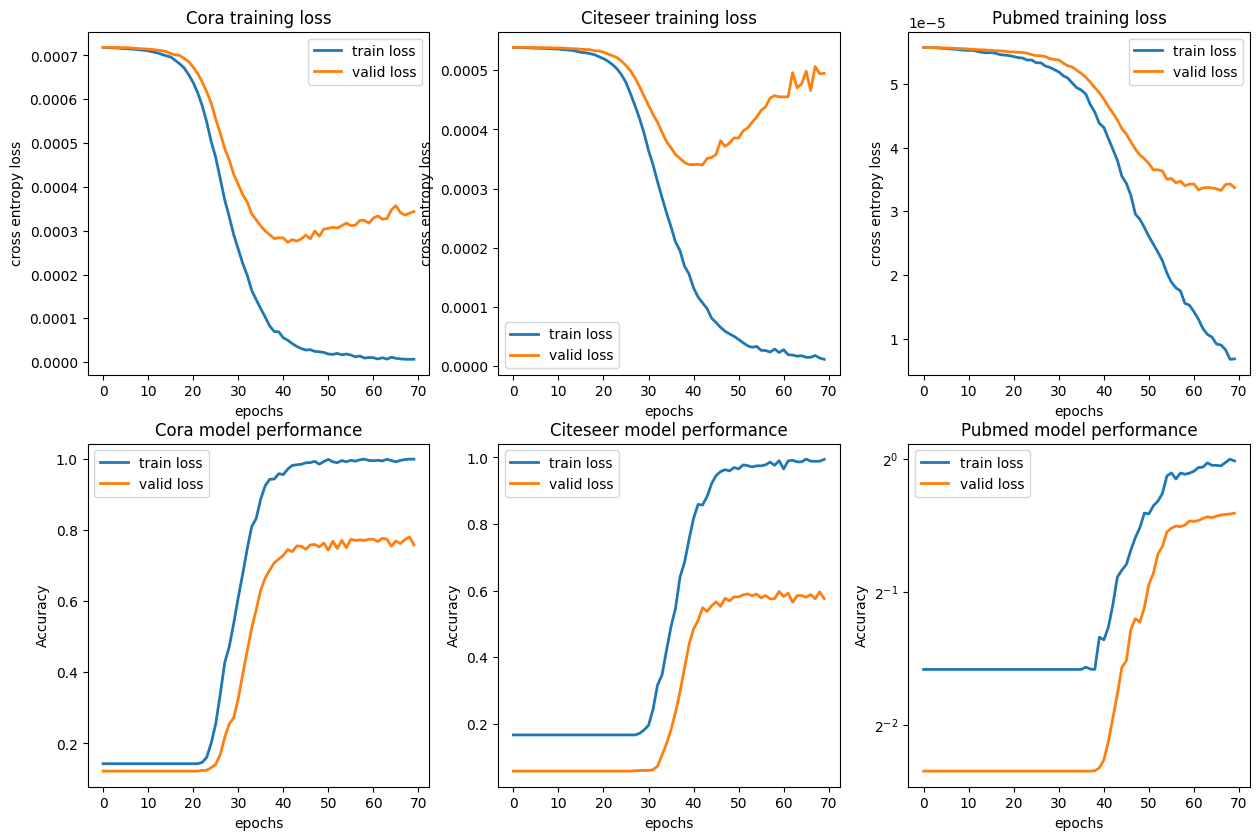

In [ ]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15, 10), dpi=100)

#cora 

axes[0][0].plot(loss_cora_train, label='train loss', linewidth=2)
axes[0][0].plot(loss_cora_valid, label='valid loss', linewidth=2)
axes[0][0].set_ylabel("cross entropy loss")
axes[0][0].set_xlabel("epochs")
axes[0][0].set_title("Cora training loss")
axes[0][0].legend()

axes[1][0].plot(acc_cora_train, label='train loss', linewidth=2)
axes[1][0].plot(acc_cora_valid, label='valid loss', linewidth=2)
axes[1][0].set_ylabel("Accuracy")
axes[1][0].set_xlabel("epochs")
axes[1][0].set_title("Cora model performance")
axes[1][0].legend()

# citeseer

axes[0][1].plot(loss_citeseer_train, label='train loss', linewidth=2)
axes[0][1].plot(loss_citeseer_valid, label='valid loss', linewidth=2)
axes[0][1].set_ylabel("cross entropy loss")
axes[0][1].set_xlabel("epochs")
axes[0][1].set_title("Citeseer training loss")
axes[0][1].legend()

axes[1][1].plot(acc_citeseer_train, label='train loss', linewidth=2)
axes[1][1].plot(acc_citeseer_valid, label='valid loss', linewidth=2)
axes[1][1].set_ylabel("Accuracy")
axes[1][1].set_xlabel("epochs")
axes[1][1].set_title("Citeseer model performance")
axes[1][1].legend()

# pubmed

axes[0][2].plot(loss_pubmed_train, label='train loss', linewidth=2)
axes[0][2].plot(loss_pubmed_valid, label='valid loss', linewidth=2)
axes[0][2].set_ylabel("cross entropy loss")
axes[0][2].set_xlabel("epochs")
axes[0][2].set_title("Pubmed training loss")
axes[0][2].legend()

axes[1][2].plot(acc_pubmed_train, label='train loss', linewidth=2)
axes[1][2].plot(acc_pubmed_valid, label='valid loss', linewidth=2)
axes[1][2].set_ylabel("Accuracy")
axes[1][2].set_xlabel("epochs")
axes[1][2].set_title("Pubmed model performance")
axes[1][2].legend()

plt.yscale('log',  basey=2)


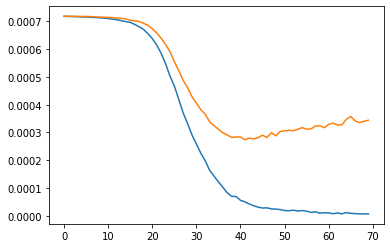

In [ ]:
plt.plot(loss_cora_train)
plt.plot(loss_cora_valid)

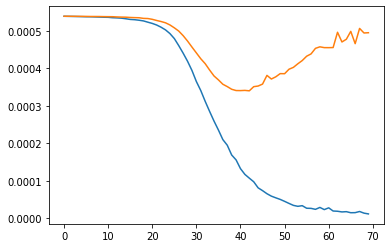

In [ ]:
plt.plot(loss_citeseer_train)
plt.plot(loss_citeseer_valid)

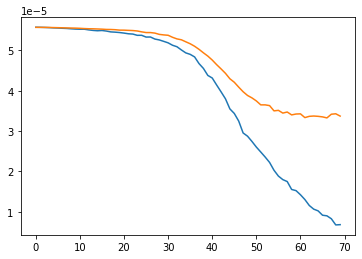

In [ ]:
plt.plot(loss_pubmed_train)
plt.plot(loss_pubmed_valid)